# Content Analysis of user complaints of the four largest Telecommunications companies in South Africa

> ℹ️ Source Code

The recommended approach to running the code is to clone the git repository from https://github.com/JohnnyFoulds/dsm020-2021-oct and open it in Visual Studio Code as a [Development Container](https://code.visualstudio.com/docs/remote/create-dev-container). This will create an environment identical to what has been used during development.

The following packages were added explicitly to the development container and will be required to execute the notebook if it is to be executed outside of VS Code.

[requirements.txt](https://github.com/JohnnyFoulds/dsm020-2021-oct/blob/master/requirements.txt)

```
ipykernel==6.4.1
ipywidgets==7.6.3
nltk==3.6.5
matplotlib==3.4.3
pandas==1.3.4
openpyxl==3.0.9
pyquery==1.4.3
requests==2.26.0
scikit-learn==0.23.2
plotly==5.4.0
pycaret==2.3.5
shap==0.40.0
pyarrow==6.0.1
bs4==0.0.1
fasttext==0.9.2
```

## I. Background

Social media have given customers various avenues to share opinions about organisations and their service levels, and organisations are acutely aware of the need to keep track and manage customer perceptions to reduce churn. Managing customer relations is essential in a marketplace where customers can easily switch between providers who provide essentially the same service where the margins for competitive advantage are small, as is the case in the telecommunications industry.

By understanding and categorising complaints, organisations can improve the customer experience by, for example, faster routing complaints to the suitable business unit for remediation and proactively identifying trends that impact customer service and perception. Mining customer reviews for insights could also potentially be used to identify new business opportunities or competitor weaknesses to further differentiate the organisation by providing a superior service.  

## II. Study Purpose

### A. Motivation and Objectives

The central objective of the proposed study is to develop a framework for analysing and categorising user-generated reviews of products or services in the telecommunications industry.

Previous studies [1] [2] investigating customer complaint behaviour have similar objectives as the proposed study, except that the researchers used manual techniques like Inductive Thematic Analysis to categorise user reviews and extract information. The drawback of this approach is that it is labour intensive and, by extension, limits the amount of content that can be analysed. Similarly, manual techniques make it impractical to regularly perform this type of analysis. In contrast, the proposed study investigates effective techniques using modern data science and machine learning that are repeatable and can accommodate the velocity of the data stream from social media sources.

Whilst topic modelling can garner actionable insights from text datasets [3], in practice, techniques such as Latent Dirichlet Allocation (LDA) often fall short since it is tough to assign meaningful labels to the topics produced. Furthermore, it is rare for the topics created through unsupervised learning to match the themes and categories found through manual context analysis. For example, for the dataset of the proposed study, the ideal output would be for reviews grouped by the service/product for which the customer is writing the review. Therefore, the proposed study will experiment with various techniques to find methods best fit for the purpose.


In [1]:
# import libraries
import pandas as pd
import requests
import datetime
from bs4 import BeautifulSoup
import fasttext
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

### B. Limitations

A single data source (as discussed below) will be used in this study, and social media platforms like Twitter or Facebook will be out of scope. However, this does not exclude the same methods to be applied to these platforms, but additional data retrieval and filtering logic will be required.

The selected data source contains compliments and complaints, but the focus will be on customer complaints. A more balanced data source can be selected for a complementary study in future research.

## III. Research Methodology

The focus of the proposed study is deriving actionable insights from textual customer reviews. Hence it will draw heavily on established Natural Language Processing techniques but potentially use concepts from NLP in novel ways to, for example, overcome some of the limitations of topic modelling as mentioned in a previous section.

### A. Data Source

Reviews from hellopeter.com will be used as the source of user reviews to analyse. As described in their blog [4], Hellopeter "is a platform connecting South African consumers and business". It allows consumers to post reviews monitored and responded to by the business to manage customer relations and resolve issues. Hellopeter is a well-known and widely used site in South Africa and was chosen because, unlike general social media, customer content is specifically related to either a compliment or complaint. Using Hellopeter also has the advantage that the methods developed in this study can easily be applied to another industry since the same primary data source can be used, and reviews will be in a similar format regardless of industry or organisation.

In practice, the reviews from Hellopeter are predominately negative, and many South Africans view it as a platform allowing them to "publicly shame" companies, thereby forcing the businesses in question to take action. Some elements of "cancel culture" is present, and companies are often accused of fraud, with phrases like "daylight robbery" frequently seen. Companies are also often threatened that they "will be taken to the lawyers", the ombudsman or "Carte Blanche" (a popular television program in South Africa sometimes featuring investigations into abuse of the vulnerable) [5].
	
Looking at a sample of reviews, it would seem that some people hold the belief that Hellopeter facilitates dispute resolution. However, again from the Hellopeter blog post, we can see that this is not the case: "Hellopeter provides a channel for consumers and businesses to directly engage with one another. This means Hellopeter doesn't engage in, or facilitate, dispute resolution." [4].

The logic for retrieving review data from Hellopeter.com is encapsulated in the class below to allow the class to be moved to a separate .py file to enable re-use and ensure that activities specifically related to the inner workings of the API have a layer of abstraction should the API change at a future date.

In [2]:
class Hellopeter():
    """
    This class is used to retrieve Hellopeter reviews via the `https://api.hellopeter.com/consumer/business/` API.

    Parameters
    ----------
    business : str
        The business name to retrieve reviews for.
    api_url : str
        The base URL used to invoke the Hellopeter API.
    """
    def __init__(self, business:str, api_url:str='https://api.hellopeter.com/consumer/business/') -> None:
        self.business = business
        self.api_url = api_url
        self.url_template = self.api_url + self.business + '/reviews?page='

        # initialize the session to use for requests to the API
        self.request_session = requests.Session()

    def request_page(self, page_number:int) -> dict:
        """
        Request a specific review page for the business.

        Parameters
        ----------
        page_number : int
            The page number to retrieve the reviews from.   

        Returns
        -------
        response_json : dict
        """
        # set the full url for the request
        url = self.url_template + str(page_number)
       
        # set the request headers
        headers = {
            'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
            'accept': 'application/json'
        }

        # request the review page
        respose = self.request_session.get(url=url)

        # implement basic error handling
        if respose.status_code == 202:
            return respose.json()
        else:
            raise Exception('An unexpected response code were received: %s' % respose.status_code)

    def process_request_page(self, page_json:dict) -> pd.DataFrame:
        """
        Process the raw JSON data of a review page and convert it to a Pandas DataFrame.

        Parameters
        ----------
        page_json : dict
            The raw JSON (represented as a Python dictionary) that was retrieved from the API.

        Returns
        -------
        page_data : pandas.DataFrame
            The page data converted to a DataFrame.            
        """
        # create the dataframe
        page_data = pd.DataFrame(page_json['data'])

        # add the business name to the dataframe
        page_data['business'] = self.business

        # basic data type conversions
        page_data.created_at = pd.to_datetime(page_data.created_at)
        page_data.replied = page_data.replied.astype('bool')        

        # return the processed page data
        return page_data

    def retrieve_reviews(self, stop_at:datetime) -> pd.DataFrame:
        """
        Retrieve reviews for the business up to, and including the `stop_at` date.

        Parameters
        ----------
        stop_at : datetime
            The date of the last review to retrieve.

        Returns
        -------
        review_data : pandas.DataFrame
            A DataFrame containing the reviews retrieved.            
        """
        page_data = pd.DataFrame()
        current_page = 1
        stop_retrieval = False

        while not stop_retrieval:
            # retrieve the reviews for the current page
            current_reviews = self.process_request_page(self.request_page(current_page))

            # add the current page to the output dataframe
            page_data = pd.concat([page_data, current_reviews])

            # increment the page counter
            current_page += 1

            # determine if data retrieval should be stopped
            #print(current_reviews.created_at.min(), stop_at)
            stop_retrieval = current_reviews.created_at.min() < stop_at

            # print a progress indicator
            if current_page % 100 == 0:
                print(current_page, current_reviews.created_at.min())

        # perform the final filter for the stop date
        page_data = page_data.query('created_at >= @stop_at')

        # return the result dataframe
        return page_data

In [3]:
def retrieve_bussiness_reviews(business:str, stop_at:datetime, output_path='data/raw/') -> pd.DataFrame:
    """
    Retrieve reviews for a business and store the output in Parquet format.

    Parameters
    ----------
    business : str
        The business name to retrieve reviews for.        
    stop_at : datetime
        The date of the last review to retrieve.    

    Returns
    -------
    review_data : pandas.DataFrame
        A DataFrame containing the reviews retrieved.     
    """
    # retrieve the reviews
    peter = Hellopeter(business)
    review_data = peter.retrieve_reviews(stop_at)

    # save the dataset
    review_data.to_parquet('data/raw/%s.gzip' % business.replace('-', '_'), 
        compression='gzip', index=False)

    # return the retrieved data for futher processing
    return review_data

### B. Ethics of Use

Data is retrieved using the Hellopeter public APIs, which provides the same content visible by browsing the website. Although, Hellopeter does provide a private interface and private API which allows verified businesses to retrieve full details of the review, including account numbers mentioned or contact numbers to reach the customer, no personally identifiable information is available using the public API as automatically Hellopeter anonymises reviews visible to the public to protect consumers.

It should be noted that data retrieval speed can be significantly improved by using parallel processing with multiple concurrent requests to the Hellopeter API. However, optimisation of data retrieval was explicitly excluded due to ethical considerations in that asynchronous-parallel data retrieval techniques will place a significant load on the API. This is to be avoided as it might cause degradation of this service and could potentially have a monetary impact as it might cause the Hellopeter infrastructure to unnecessarily scale out due to the sharp increase.


 ### C. Data Retrieval

> ❗Please do not execute the cells below unless new data is required. Retrieving the data is a long-running operation. The reviews retrieved on `2022/01/01` is available in Parquet format on [GitHub](https://github.com/JohnnyFoulds/dsm020-2021-oct/tree/master/coursework_01/data/raw).

In [4]:
# retrieve the vodacom dataset
vodacom_reviews = retrieve_bussiness_reviews(business='vodacom', stop_at=datetime.datetime(2021, 1, 1))

100 2021-11-30 14:30:38
200 2021-11-01 15:39:32
300 2021-10-01 14:51:30
400 2021-08-27 11:53:15
500 2021-07-22 11:16:39
600 2021-06-18 09:38:57
700 2021-05-18 00:56:35
800 2021-04-20 10:16:59
900 2021-03-24 08:39:09
1000 2021-03-01 15:21:01
1100 2021-02-07 19:43:44
1200 2021-01-14 10:35:14


In [5]:
# retrieve the mtn dataset
mtn_reviews = retrieve_bussiness_reviews(business='mtn', stop_at=datetime.datetime(2021, 1, 1))

100 2021-11-10 09:42:35
200 2021-09-15 12:59:40
300 2021-07-28 10:28:37
400 2021-06-01 13:21:51
500 2021-04-07 16:14:40
600 2021-02-24 11:04:20
700 2021-01-18 11:19:33


In [6]:
# retrieve the telkom dataset
telkom_reviews = retrieve_bussiness_reviews(business='telkom', stop_at=datetime.datetime(2021, 1, 1))

100 2021-10-29 17:31:19
200 2021-08-30 11:55:16
300 2021-07-01 19:17:42
400 2021-05-10 12:00:59
500 2021-03-20 07:34:14
600 2021-02-08 16:12:03
700 2021-01-01 12:22:05


In [7]:
# retrieve the cell-c dataset
cell_c_reviews = retrieve_bussiness_reviews(business='cell-c', stop_at=datetime.datetime(2021, 1, 1))

100 2021-10-19 11:16:50
200 2021-08-18 09:12:53
300 2021-06-09 09:34:42
400 2021-03-26 12:08:53
500 2021-01-27 15:38:19


 ## IV. Data Selection

> ℹ️ Data is loaded from the GitHub repository instead of locally saved files. This is under the assumption that this notebook will be submitted as a coursework piece with a size limitation on submission size.

In [8]:
# load the raw datasets retrieved fom hellopeter
vodacom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/vodacom.gzip')
mtn_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/mtn.gzip')
telkom_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/telkom.gzip')
cell_c_reviews = pd.read_parquet('https://github.com/JohnnyFoulds/dsm020-2021-oct/raw/master/coursework_01/data/raw/cell_c.gzip')

### A. Combine Datasets

The datasets are combined into a single Data Frame as this is useful for preparing the data and performing analysis across the different telecommunications providers.

In [9]:
df_reviews = pd.concat([vodacom_reviews, mtn_reviews, telkom_reviews, cell_c_reviews])
df_reviews.reset_index(inplace=True, drop=True)
df_reviews.shape

(35132, 28)

Get a basic overview of the dataset to select the columns of interest.

In [10]:
# get a basic summary of the dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35132 entries, 0 to 35131
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35132 non-null  int64         
 1   user_id                     35132 non-null  object        
 2   created_at                  35132 non-null  datetime64[ns]
 3   authorDisplayName           35132 non-null  object        
 4   author                      35132 non-null  object        
 5   authorAvatar                35132 non-null  object        
 6   author_id                   35132 non-null  object        
 7   review_title                35132 non-null  object        
 8   review_rating               35132 non-null  int64         
 9   review_content              35132 non-null  object        
 10  business_name               35132 non-null  object        
 11  business_slug               35132 non-null  object    

In [11]:
# convert author_created_date to the datetime type
df_reviews.author_created_date = pd.to_datetime(df_reviews.author_created_date)

# convert the id to string
df_reviews['id'] = df_reviews['id'].astype('str')

In [12]:
# get a sample of the data
df_reviews.sample(n=5, random_state=118)

,id,user_id,created_at,authorDisplayName,author,authorAvatar,author_id,review_title,review_rating,review_content,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business
5051,3578165,f66d3530-322e-11ea-b378-9d9b42609b27,2021-07-31 08:49:35,Brian R,Brian R,,f66d3530-322e-11ea-b378-9d9b42609b27,VODACOM FIBRE UNHELPFULL,1,SR**********96 Fibre's been offline for a week...,...,telecommunications,1,NaN,WEBSITE,False,None,2020-01-08,2,[],vodacom
4856,3584982,fe6410e0-8f4c-11e9-98c7-c365b64ec7b8,2021-08-05 19:03:48,Mahomed M,Mahomed M,,fe6410e0-8f4c-11e9-98c7-c365b64ec7b8,Faulty vodacom application,2,When paying on application R559 July tariff th...,...,telecommunications,1,NaN,WEBSITE,False,None,2019-06-15,135,[],vodacom
21780,3745879,be2bf020-51e5-11e8-8a73-dbe5d90e7d04,2021-12-17 12:36:43,Rofhiwa T,Rofhiwa T,,be2bf020-51e5-11e8-8a73-dbe5d90e7d04,Fibre connection,1,If it was possible to give telkom a minus rati...,...,telecommunications,1,NaN,WEBSITE,False,None,2018-05-07,6,[],telkom
34613,3373141,1b4039b3-31fa-11e8-83f4-f23c91bb6188,2021-02-01 09:47:13,Wynand,Wynand,,1b4039b3-31fa-11e8-83f4-f23c91bb6188,Cell C so disappointing....,1,I have a data contract with Cell C - never mis...,...,telecommunications,1,NaN,WEBSITE,False,None,2014-06-02,5,[],cell-c
5118,3574981,0ce8b5d2-31fa-11e8-83f4-f23c91bb6188,2021-07-28 15:04:40,Steven,Steven,,0ce8b5d2-31fa-11e8-83f4-f23c91bb6188,Should be ashamed to call yourself a telecoms ...,1,Someone contact me on ********** I have brough...,...,telecommunications,1,NaN,WEBSITE,False,None,2012-08-31,2,[],vodacom


> ℹ️ When ten rows were retrieved using the same seed value as above, it revealed that not all reviews are in English. Therefore, it might be beneficial to remove reviews not in English when performing NLP analysis.

In [13]:
# example review in Afrikaans
df_reviews.loc[23943].review_content

"Ek en my man ontvang elke maand 'n rekening van Telkom af in ons naam. Account no: **********01 en Service Ref: ********** met VAT no: **********. Ek was al 4 keer indien nie meer by Telkom om die rekening uit te sorteer omrede die VATno nie ons praktyk se nommer is nie en aangesien die Service Nommer 'n telefoonnomer is in Rustenburg en ons woon in George. Maar let wel die rekening is in my man se naam. Wat staan ons te doen want dit is 'n lost case!!!!!!"

### B. Remove Columns

The steps below investigate redundant columns or columns with limited data that can be removed. For example, the sample data shows that `authorDisplayName` and `author` might contain identical values. Although the results from `.info` indicate non-null values in `authorAvatar`, the sample seems to indicate that these values might be blank and need further investigation.

An initial overview of the data shows that the following should be investigated:
- `authorDisplayName` and `author` for identical values
- `authorAvatar` for blank values
- Only about `43%` of the rows contain values for `nps_rating`
- `business_reporting` contains almost exclusively null values.


#### 1) Investigate the author columns

In [14]:
df_reviews.query('authorDisplayName != author')

,id,user_id,created_at,authorDisplayName,author,authorAvatar,author_id,review_title,review_rating,review_content,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business


In [15]:
# drop the authorDisplayName column as it is redundant
df_reviews.drop('authorDisplayName', inplace=True, axis=1)

The `user_id` and `author_id` seems to contain the same data.

In [16]:
df_reviews.query('user_id != author_id')

,id,user_id,created_at,author,authorAvatar,author_id,review_title,review_rating,review_content,business_name,...,industry_slug,status_id,nps_rating,source,is_reported,business_reporting,author_created_date,author_total_reviews_count,attachments,business


In [17]:
df_reviews.drop('user_id', inplace=True, axis=1)

#### 2) Investigate the authorAvatar column

In [18]:
# a simple test is to look for the number of distinct values
authorAvatar_summary = df_reviews.authorAvatar.value_counts().to_frame()
authorAvatar_summary

,authorAvatar
,35038
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/2016-05-07-HP_Aitog.png,8
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_mvJ2A515nUUUJfdrXXDC.jpg,5
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_aVekA5CY8H7GLbu8Ftah.jpg,3
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_SCZVHD6jBklLKYk2sCA2.jpg,3
...,...
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_IeZM8LiSxfOYlzeUo6TR.jpg,1
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_w9917iADjBmKdbEI6KIM.jpg,1
http://pbs.twimg.com/profile_images/2554977605/Fmanu.jpeg,1
https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_trr2esjlsyhjKp3gt8Mi.jpg,1


Unfortunately, `99.7%` of the avatar images are blank, so this column can be removed. If avatar images were prevalent, this information could have contained useful hidden information where the images could, for example, be analysed to identify users with cartoon images (https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/2016-05-07-HP_Aitog.png) and users with "real" images (https://s3-us-west-2.amazonaws.com/hp-cdn-01/uploads/users/avatars/avatar_aVekA5CY8H7GLbu8Ftah.jpg).

Object detection in the avatar images could also have revealed helpful information, and the information from the images could be used as additional features that could perhaps serve as a proxy of the user's personality. The analysis of avatar images to produce additional features and the validity of this method is interesting and should be explored as potential future research.

In [19]:
df_reviews.drop('authorAvatar', inplace=True, axis=1)

#### 3. Investigate the nps_rating column

The Net Promoter Score (NPS) is collected by asking reviewers to rate on a scale from 0 to 10 _"how likely are they to refer your business to a friend or colleague?" [6]. It is unlikely that all reviewers will respond to this email. Calculate the ratio of reviews to NPS ratings in the cell below to determine if the NPS column should be kept.

In [20]:
# get the number of reviews with a nps_rating per business
df_nps_rating = df_reviews[~df_reviews.nps_rating.isnull()][['business_name', 'nps_rating']]
df_nps_rating_grouped = df_nps_rating.groupby(by=['business_name']).count()

# get a summary of the total reviews per business
df_business_name_grouped = df_reviews.business_name.value_counts().rename_axis('business_name').to_frame('counts')

# join the data to calculate the ration
df_nps_rating_joined = df_nps_rating_grouped.join(df_business_name_grouped)

# calculate the ratio
df_nps_rating_joined['ratio'] = df_nps_rating_joined.nps_rating / df_nps_rating_joined.counts
df_nps_rating_joined


,nps_rating,counts,ratio
business_name,,,
Cell C,2515,5830,0.431389
MTN South Africa,3738,8000,0.467250
Telkom,3284,7576,0.433474
Vodacom,5550,13726,0.404342


The ratios between the four telecommunications businesses seem similar, and the NPS rating can be retained. However, when the NPS score is used as a feature, it might be best to take a sample from only the subset of data with a non-null value.

#### 4) Investigate the business_reporting column

In [21]:
df_reviews.business_reporting.astype('str').value_counts().to_frame('counts').head(5)

,counts
None,35033
"{'created_at': '2021-10-25T11:35:59.000000Z', 'id': 68744.0, 'org_id': 793962.0, 'reason_id': 3.0, 'relationship_id': 1.0, 'report_reason': ""Kindly note, our firm does not deal with Blacklisting. Also, as per our clients T&C's, the final bill needs to be paid 30 days after the account is cancelled, we also do assist with a dispute only if same is valid."", 'reporter_contact': None, 'reporter_email': 't12@rpplaw.co.za', 'reporter_name': 'Caleb Ryce', 'review_id': 2616707.0, 'slug': 'kindly-note-our-firm-does-not-deal-with-blacklisting-also-as-per-our-clients-tcs-the-final-bill-needs-to-be-paid-30-days-after-the-account-is-cancelled-we-also-do-assist-with-a-dispute-only-if-same-is-valid-1635161759', 'status': 'RESOLVED', 'updated_at': '2021-10-25T11:49:07.000000Z'}",1
"{'created_at': '2021-03-09T09:23:18.000000Z', 'id': 54650.0, 'org_id': 793962.0, 'reason_id': 6.0, 'relationship_id': 1.0, 'report_reason': 'How can this review be 5 stars but he is complaining about Telkom defrauding him ??', 'reporter_contact': '0615071739', 'reporter_email': 'jfsteffens1@gmail.com', 'reporter_name': 'Johan Steffens', 'review_id': 3418669.0, 'slug': 'how-can-this-review-be-5-stars-but-he-is-complaining-about-telkom-defrauding-him-1615281798', 'status': 'RESOLVED', 'updated_at': '2021-03-09T09:27:25.000000Z'}",1
"{'created_at': '2021-03-31T08:54:28.000000Z', 'id': 56137.0, 'org_id': 793962.0, 'reason_id': 6.0, 'relationship_id': 1.0, 'report_reason': 'I found out that my FUP is not active but I have a unlimited ADSL account they not honest with us as they customers so they hide it from us. \n', 'reporter_contact': '0835748525', 'reporter_email': 'donovan.pietersen8@gmail.com', 'reporter_name': 'Donovan Pietersen', 'review_id': 3444174.0, 'slug': 'i-found-out-that-my-fup-is-not-active-but-i-have-a-unlimited-adsl-account-they-not-honest-with-us-as-they-customers-so-they-hide-it-from-us-1617180868', 'status': 'RESOLVED', 'updated_at': '2021-03-31T09:18:18.000000Z'}",1
"{'created_at': '2021-05-06T20:40:49.000000Z', 'id': 58230.0, 'org_id': 793962.0, 'reason_id': 8.0, 'relationship_id': 1.0, 'report_reason': ""Telkom is the dumbest network they rob their customers they won't be getting a cent from me"", 'reporter_contact': '0651963069', 'reporter_email': 'Jannelmarimuthu@gmail.com', 'reporter_name': 'Juliesha ', 'review_id': 3483926.0, 'slug': 'telkom-is-the-dumbest-network-they-rob-their-customers-they-wont-be-getting-a-cent-from-me-1620333649', 'status': 'RESOLVED', 'updated_at': '2021-05-07T05:20:54.000000Z'}",1


This column contains interesting information, but almost none of the reviews have this populated. Hence the column will be removed.

In [22]:
df_reviews.drop('business_reporting', inplace=True, axis=1)

#### 5) Investigate the attachments column

In [23]:
df_reviews.attachments.astype('str').value_counts()

[]    35132
Name: attachments, dtype: int64

In [24]:
# drop the attachments column as it always appears as an empty array
df_reviews.drop('attachments', inplace=True, axis=1)

#### 6) Investigate the status_id column

Determine if this column contains different codes of if the value is uniform.

In [25]:
df_reviews.status_id.value_counts()

1    35132
Name: status_id, dtype: int64

In [26]:
# the column always contain the same value and can be removed
df_reviews.drop('status_id', inplace=True, axis=1)

#### 7) Investigate the source column

In [27]:
df_reviews.source.value_counts()

WEBSITE                    34841
WHATSAPP                     287
IN_MAIL_EMAIL_INVITE           1
PORTAL_COPY_LINK_INVITE        1
Name: source, dtype: int64

In [28]:
df_reviews[['business_slug', 'source', 'id']].groupby(['source', 'business_slug']).count()

id
source                  business_slug       
IN_MAIL_EMAIL_INVITE    vodacom            1
PORTAL_COPY_LINK_INVITE mtn                1
WEBSITE                 cell-c          5779
                        mtn             7944
                        telkom          7481
                        vodacom        13637
WHATSAPP                cell-c            50
                        mtn               55
                        telkom            94
                        vodacom           88

There seems to be incredibly low adoption of all the channels besides `WEBSITE`, with the numbers being so small that this feature will not be helpful as a dataset feature.

In [29]:
df_reviews.drop('source', inplace=True, axis=1)

#### 8) Investigate the is_reported column

In [30]:
df_reviews.is_reported.value_counts()

False    35020
True       112
Name: is_reported, dtype: int64

In [31]:
# this is another column that is mostly uniform and can be removed
df_reviews.drop('is_reported', inplace=True, axis=1)

#### 9) Remove Columns with redundant data

In [32]:
# drop the business column that was added during a data retrieval as the same information is contained in `business_name`
df_reviews.drop('business', inplace=True, axis=1)

# remove bussiness_slug as this is essentially the same as business_name
df_reviews.drop('business_name', inplace=True, axis=1)

# the business logo is not a useful feature and can be removed
df_reviews.drop('business_logo', inplace=True, axis=1)

# the industry logo will not be a useful feature for analysis as it is merely cosmetic and the entire dataset is from the same industry
df_reviews.drop('industry_logo', inplace=True, axis=1)

# similarly to the business name, the industry_name name will be removed in favour of the industry_slug (used in urls etc.)
df_reviews.drop('industry_name', inplace=True, axis=1)

In [33]:
# get a sample of the data
df_reviews.sample(n=5)

,id,created_at,author,author_id,review_title,review_rating,review_content,business_slug,permalink,replied,messages,industry_slug,nps_rating,author_created_date,author_total_reviews_count
34869,3354663,2021-01-16 08:10:46,Mark E,507bfb30-b192-11ea-b90d-016e01fe622e,CELL C DO NOT HONOR THERE WORD...,1,Cell C Limited operates as a customer-first mo...,cell-c,cell-c-do-not-honor-there-word-3354663,True,[{'body': '<div>Good day Mark&nbsp;<br><br>Tha...,telecommunications,NaN,2020-06-18,3
29754,3712881,2021-11-23 09:43:19,Nokuthula M,9f773140-4c2f-11ec-a79f-db0a6b646fb3,Kriel Network,1,I wrote an email to cell c that at Kriel Mpum...,cell-c,kriel-network-3712881,True,"[{'body': 'The business has replied privately,...",telecommunications,NaN,2021-11-23,1
9030,3453095,2021-04-08 22:38:52,Samantha B,0725fe40-91b6-11e9-a966-832d929b77f8,Vodacom Fibre - never ever again!!!,1,Vodacom fibre is completely useless. Been with...,vodacom,vodacom-fibre-never-ever-again-3453095,True,[{'body': '<div>&nbsp;</div><div>Dear Customer...,telecommunications,NaN,2019-06-18,5
32313,3534556,2021-06-22 12:00:26,Mpetshe B,daa84240-e09e-11ea-94d2-af6b19e0a459,Cell c sucks,1,Cell c is the worst company I ever dealt withi...,cell-c,cell-c-sucks-410495d06d9d74f7c3e86c53d1b5742c1...,True,[{'body': '<div>Good day Mpetshe&nbsp;<br><br>...,telecommunications,NaN,2020-08-17,7
67,3748077,2021-12-20 10:07:31,Shane A,050bf62d-31fa-11e8-83f4-f23c91bb6188,Double payment. Not being transparent on charges,3,"Good day,\n\nPlease note I already paid the up...",vodacom,double-payment-not-being-transparent-on-charge...,True,"[{'body': '<div>Dear Customer,</div><div>&nbsp...",telecommunications,NaN,2011-06-30,2


## V. Data Preparation

### A. Validation Checks

From the simple check below, the dataset appears to be in a good state as only the `nps_rating` column contains empty values, which is expected, as discussed in a previous section

In [34]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35132 entries, 0 to 35131
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          35132 non-null  object        
 1   created_at                  35132 non-null  datetime64[ns]
 2   author                      35132 non-null  object        
 3   author_id                   35132 non-null  object        
 4   review_title                35132 non-null  object        
 5   review_rating               35132 non-null  int64         
 6   review_content              35132 non-null  object        
 7   business_slug               35132 non-null  object        
 8   permalink                   35132 non-null  object        
 9   replied                     35132 non-null  bool          
 10  messages                    35132 non-null  object        
 11  industry_slug               35132 non-null  object    

Looking at the distributions of `review_rating` (a star from 1-5) and `nps_rating` (an industry-standard rating from 0-10), we can see that reviews submitted to Hellopeter.com are almost exclusively negative and does not provide a balanced view of the companies in question. However, this outcome was expected from the outset, and in the context of this study, Hellopeter is a source for _customer complaints_ and not for _reviews_ where a less skewed dataset would be present.

In [35]:
df_reviews.describe()

,review_rating,nps_rating,author_total_reviews_count
count,35132.000000,15087.000000,35132.000000
mean,1.173859,1.179492,7.840373
std,0.720003,2.474153,15.903602
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,1.000000,8.000000
max,5.000000,10.000000,738.000000


> ❗The max value of `author_total_reviews_count` seems too large and justifies further investigation.

These data should be examined for potential automated or fake reviews. For example, `Neleshnee N` appears to be submitting excessive reviews on Hellopeter, and `Lynne S` is also suspicious as the account is relatively new and has already accumulated over 200 reviews.

In [36]:
df_reviews[['author', 'author_created_date', 'author_total_reviews_count']].drop_duplicates().sort_values(by='author_total_reviews_count', ascending=False).head(10)

,author,author_created_date,author_total_reviews_count
31165,Neleshnee N,2018-11-20,738
424,Frans,2011-07-06,456
23711,Premilla D,2016-05-18,445
21560,ABDUL-KADER EBRAHIM,2015-06-18,269
3037,gerard,2009-03-27,262
6507,Quinton Henry-Taylor,2015-02-02,253
5018,Philip,2014-11-10,248
24686,Paul R,2016-05-03,222
16379,Lynne S,2020-03-02,218
24425,Ranjan D,2011-02-21,215


### B. Remove HTML Tags

Natural Language Processing (NLP) techniques will be used to analyse the data contained in the `review_title` and `review_content` columns. If these columns contain HTML markup, strip the tags, and create a new column with the cleaned text.

The `messages` column does contain HTML tags but will not be processed at this stage as this column contain replies to the original review.

In [37]:
# the regular expression to use for detecting html tags
tag_exp = r'<[^<>]+>'

# find rows with html in the review title
df_reviews[df_reviews.review_title.str.contains(tag_exp)].shape

(0, 15)

In [38]:
# since there were no tags in the reviews no tags need to be replaced
df_reviews['review_title_clean'] = df_reviews.review_title

None of the values in the `review_title` requires HTML clean-up, but as shown below, stripping HTML tags will be beneficial on the `review_content` column.

In [39]:
# find rows with html in the review content
html_content = df_reviews[df_reviews.review_content.str.contains(tag_exp)]
print('Reviews with HTML Tags: %d' % html_content.shape[0])

# print two sample reviews to use for verification after stripping tags
print('=== Sample Review: %s - %s' % (html_content.index[5], html_content.iloc[5].review_content))
print('=== Sample Review: %s - %s' % (html_content.index[1], html_content.iloc[1].review_content))

Reviews with HTML Tags: 118
=== Sample Review: 1927 - <div>My late wife subscribe to a funeral policy at Vodacom. She past away on the 2 nd July 2021, I struggle to get the claim to be paid out , every time the have another story can you help me with this issue, plse</div>
=== Sample Review: 508 - We have a Vodacom contract at our business.  The contract was due to come to an end, to which I was sent an email by Singh, Lavashni, Vodacom (External) <***********> with a subject line "Sim Upgrade Processed" which informed me of an upgrade done on the business package, to which no authorization was granted to as the person emailed is not the person that is supposed to authorize the package upgrade.  I requested her to revert everything and speak to the finance department before going ahead with the upgrade and no forms / documents to confirm the upgrade was submitted.  The email that followed informed me that the phones where upgraded without confirming that the phones were still needed OR

In [40]:
# use beautifulsoup to remove html tags
df_reviews['review_content_clean'] = [BeautifulSoup(text).get_text() for text in df_reviews['review_content'] ]

/home/vscode/.local/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "https://www.facebook.com/**********61803/posts/**********150954/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [41]:
# show cleaned text for comparison
print('=== 1927:', df_reviews.loc[1927].review_content_clean)
print('=== 508:', df_reviews.loc[508].review_content_clean)

=== 1927: My late wife subscribe to a funeral policy at Vodacom. She past away on the 2 nd July 2021, I struggle to get the claim to be paid out , every time the have another story can you help me with this issue, plse
=== 508: We have a Vodacom contract at our business.  The contract was due to come to an end, to which I was sent an email by Singh, Lavashni, Vodacom (External) <***********> with a subject line "Sim Upgrade Processed" which informed me of an upgrade done on the business package, to which no authorization was granted to as the person emailed is not the person that is supposed to authorize the package upgrade.  I requested her to revert everything and speak to the finance department before going ahead with the upgrade and no forms / documents to confirm the upgrade was submitted.  The email that followed informed me that the phones where upgraded without confirming that the phones were still needed OR speaking to our finance department before continuing.  on top of that,

### C. Language Detection

As mentioned in a previous section, the dataset contains some reviews that are not in English. Below the [fastText](https://fasttext.cc/docs/en/language-identification.html) library is used to add the `review_language` column. This column can be used to filter for only English reviews for NLP analysis.

In [42]:
def language_detection(text_series:pd.Series, pretrained_model:str='model/fasttext/lid.176.ftz') -> pd.Series:
    """
    Perform language detection on text in the Pandas series and return a new series containing that can be joined to the original.

    Parameters
    ----------
    text_series : pandas.Series
        The data to perform language detection on.
    pretrained_model : str
        Path to the pre-trained fastText model used for language detection
    
    Returns
    -------
    text_language : pandas.Series
    """
    print(type(text_series))
    # load the language model
    lang_model = fasttext.load_model(pretrained_model)

    # remove newline characters
    text_series = text_series.replace(r'\n', ' ', regex=True)

    # convert the text to lower case as it does seem to influence the langues detected if it is all caps
    text_series = text_series.str.lower()

    # predict the language used for each item in the series
    lang_pred = lang_model.predict(text_series.to_list())

    # only the language code from the label is required
    lang_pred = [pred[0].replace('__label__', '') for pred in lang_pred[0]]

    # get the output series (with original index values) to return
    df_result = text_series.to_frame()
    df_result['text_language'] = lang_pred

    return df_result.text_language


# perform the language detection
df_reviews['text_language'] = language_detection(df_reviews.review_content_clean)

<class 'pandas.core.series.Series'>


Perform basic validation on the predicted values. The expected result is that most reviews should be in English, some reviews in Afrikaans (related to Dutch and German) and a minority of reviews in some of the other African languages. 

> ℹ️ It is interesting to note that the below analysis revealed that the language detection is less accurate when the text is entirely in uppercase letters. For this reason, the review text has been converted to lower case in previous sections after this became evident.

In [43]:
df_reviews.text_language.value_counts().to_frame()

,text_language
en,35072
af,31
nl,20
ceb,1
sh,1
fr,1
it,1
sco,1
lb,1
id,1


In [44]:
def show_lang_sample(data:pd.DataFrame, lang_code:str, n:int, random_state:int = None):
    """
    Show a sample of reviews to validate the language detection.

    Parameters
    ----------
    data : pandas.DataFrame
        This dataframe is expected to have the `text_language` and `review_content_clean` columns.
    lang_code : str
        The language code to filter on.
    n : int
        The number of samples to show.
    random_state : int
        The random seed value for repeatable results.

    Returns
        output : str
    """
    # filter the dataset by language code
    df_lang = data[data.text_language == lang_code]

    # ensure that the sample size is not bigger than the dataset size
    n = n if n < df_lang.shape[0] else df_lang.shape[0]
    
    # create the header
    output = []
    output.append('|Review Content : %s (%d)|' % (lang_code, df_lang.shape[0]))
    output.append('|-|')

    # output the sample records
    if (n > 0):
        for index, row in df_lang.sample(n=n, random_state=random_state).iterrows():
            output.append('|%s|' % row.review_content_clean.replace('|', '-').replace('\n', ' '))

    return '\n'.join(output)

In [45]:
md(show_lang_sample(df_reviews, 'nl', 5))

|Review Content : nl (20)|
|-|
|Wat n Ongelooflike ervaring om n Kontrak te doen deur Mnr Kevin Witbooi van Vodacom Riversdal. Sy professionaliteit spreek boekdele en elke vraag is ten volle beantwoord.|
|Dit was en is steeds n nagmere om met hulle te probeer upgrade op my sel no **********. Diens uiters swak.|
|Uiters swak, geen diens, ek het in Desember by hul kantoor in Matlosana Mall gaan vra dat hul my landlyn van een kant van ons huis  na ander kant van ons huis moet kom skuif , sedertdien was ek al weer twee keer by hul kantoor in mall en bel ek weekliks maar niemand help of stel belang om te help nie, ek is raadop aangesien my printer faks en scanner nou nie kan werk nie, ek het tot vandag industrieële gebied toe gery en die ou tegniese afdeling van telkom besoek net om te hoor hul bestaan al 2jaar nie meer hier nie, ek moet alles per foon doen, en daardie diens kan netso wel nie bestaan nie|
|Vodacom Account I********** payment of R367.61 made by myself.   Please note, THAT I OWE you after this payment NOTHING, please be so kind to remove the UPGRADE which I never sign - or agree on 29 SEPTEMBER 2021 from my name. The phone is switch of, you will not be able to reach me, reason is, so that no one can say I use your airtime or data.   EK IS KLAAR MET VODACOM, julle het darem die laaste 18 maande baie geld uit my, vir foon wat ek nie eers gebruik nie!!  GEEN VERDERE BETALING SAL DEUR MY GEMAAK WORD VIR ENIGE ANDER SOGENAAMDE BEDRAE WAT EK DALK VOLGENS JULLE NOG SKULD NIE, EK IS KLAAR MET JULLE, SWAK DIENS!!|
|Julle skelm bliksems MTN!!! Subscribe my sommer automaties aan julle stupit games en vat al my airtime!!!!! Kan nie wag dat ek my kontrak kan kanseleer nie!!! Foute maak kan ek nog vat maar die blantante skelm geit maak my demoerend!!! |

All reviews detected as Dutch (NL) is indeed Afrikaans reviews as the two languages are closely related. Thus the dataset is updated appropriately below.

In [46]:
df_reviews.loc[df_reviews.text_language == 'nl', 'text_language'] = 'af'

As shown below, languages not detected as either English or Afrikaans are noticeably short English reviews, so it makes sense that the language detection model did not have sufficient data available to make an accurate prediction.

In [47]:
# review all other detected languages
other_lang = df_reviews.query('text_language not in ["en", "af"]')
other_lang.text_language = 'other'
md(show_lang_sample(other_lang, 'other', 10))

/usr/local/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


|Review Content : other (9)|
|-|
|Unable to access Vodacom app|
|Master spammers in SA|
|Test|
|Exploitation tendencies |
|Telkom & Vumatel |
|Vodacom.stealing clients airtime.|
|Airtime loaded and boom  airtime gone|
|HellKom|
|Unauthorized deibt order from my account|

> ℹ️ Since the dataset contains very few reviews not in English, reviews in other languages will be removed from the dataset as these reviews have virtually no predictive power in such small numbers.

In [48]:
# remove the rows and drop the text language column as it now contain a uniform value
df_reviews = df_reviews.query('text_language == "en"')
df_reviews.drop('text_language', inplace=True, axis=1)

In [49]:
# reset the dataframe index
df_reviews.reset_index(drop=True, inplace=True)
df_reviews.shape

(35072, 17)

### D. Natural Language Processing

Applying typical NLP pre-processing techniques such as tokenisation, stop word removal, or stemming is out of scope at this stage in the project proposal. Instead, various techniques will be used in the next project stage that will not necessarily require the same pre-processing steps. By leaving the textual review content as close as possible to the raw data, artificial limitations are not introduced, and the specific pre-processing will be done as required by the techniques in the next step. For example, while TF-IDF and dimensionality reduction can quickly be made on the dataset at this point, this will be a wasted effort if a large language model such as BERT is selected in the next stage.

In [51]:
# save the prepared dataset
df_reviews.to_parquet('data/output/telecommunications.gzip', compression='gzip', index=False)

## VI. Exploratory Data Analysis

In [52]:
# set the colors per provider
palette = sns.color_palette('tab10')
telecom_colors = [palette[2], palette[1], palette[0], palette[3]]
telecom_pallet = sns.color_palette(telecom_colors)

# set the plot style
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize":(12, 5)})
sns.set_palette(telecom_colors)

# exclude all data from 2022
stop_at = datetime.datetime(2022, 1, 1)
df_eda = df_reviews.query('created_at < @stop_at').sort_values(by='business_slug').reset_index(drop=True)

# add derived columns for analysis
df_eda['replies'] = df_eda.replied.astype('int')
df_eda['review_length'] = df_eda.review_content_clean.str.len()


Vodacom is the largest mobile network operator in South Africa with `45.4` million subscribers, followed by MTN South Africa with `33.5` million subscribers [7].

In [53]:
df_subscribers = pd.DataFrame({
    'business_slug': ['vodacom', 'mtn', 'telkom', 'cell-c'],
    'subscribers':   [45.4, 33.5, 16.3, 12.9]
}).sort_values(by='business_slug')

df_subscribers.sort_values(by='subscribers', ascending=False)

,business_slug,subscribers
0,vodacom,45.4
1,mtn,33.5
2,telkom,16.3
3,cell-c,12.9


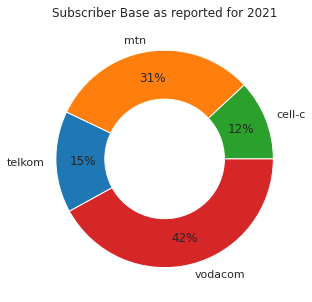

In [54]:
plt.pie(
    data=df_subscribers,
    x='subscribers',
    labels = 'business_slug', 
    colors = telecom_colors, 
    pctdistance=0.75,
    autopct='%.0f%%')

my_circle=plt.Circle( (0,0), 0.55, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Subscriber Base as reported for 2021")
plt.show()

### A. Review Ratings

The chart below show the number of reviews per month for each provider. There appears to be some seasonality in the data, with higher numbers between January and March and then reducing towards the end of the year. The exception here is Cell C which has an increase in August, which matches the peak in March – it would be of interest to determine what market conditions caused this, and it might be related to this. When the complete review analysis is done, the reviews for this provider might provide some insight into the change.

In [55]:
# group the ratings by month per bussiness
df_grouped_month = df_eda.groupby('business_slug').resample('M', on='created_at').agg({
    'replied': 'count', 
    'review_rating': 'mean',
    'nps_rating': 'mean',
    'id': 'count',
    'replies': 'sum',
}).rename(columns = {'id':'counts'})

df_grouped_month['month'] = df_grouped_month.index.get_level_values('created_at').strftime('%b')
#df_grouped_month

[Text(0.5, 1.0, '2021 Review Count'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Reviews')]

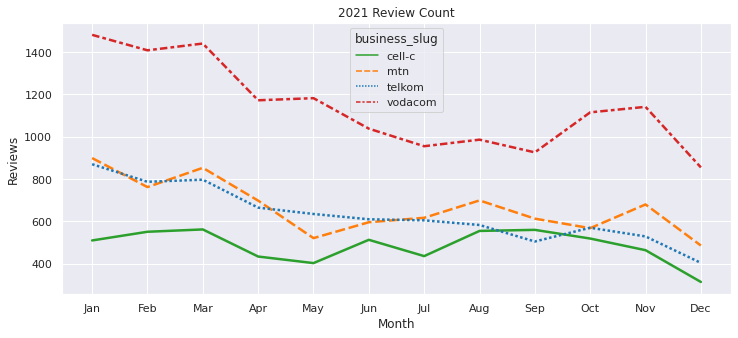

In [56]:
sns.lineplot(
    data=df_grouped_month,
    x='month',
    y='counts',
    hue='business_slug',
    style='business_slug',
    linewidth=2.5).set(
        title='2021 Review Count',
        xlabel='Month',
        ylabel='Reviews')

The rating distribution confirms very few positive reviews present in the dataset.

[Text(0.5, 1.0, '2021 Ratings'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Rating')]

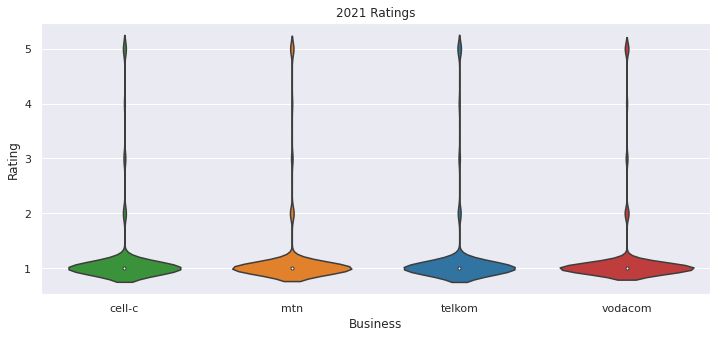

In [57]:
sns.violinplot(
    data=df_eda,
    x="business_slug", 
    y="review_rating").set(
        title='2021 Ratings',
        xlabel='Business',
        ylabel='Rating')    

### B. Net Promoter Score

The plot below shows the NPS distribution for the largest telecommunications providers in South Africa. While considering that Hellopeter almost exclusively attracts angry customers, we can tentatively conclude that _Vodacom_ and _Cell C_ might be the two best companies to choose from as they score somewhat better on the NPS ratings.

However, this data could also depict something more. For example, it is possible that how customer service handled the complaints could have resulted in a better rating after the issue was resolved. The hypothesis would be the same in that the two mentioned companies are possible the better choices by having better customer service departments.

Based on only this data in conjunction with the customer base of each provider, _Vodacom_ might be the company to choose as the NPS distribution looks more spread out, and it is the larger of the two organisations with a more extensive cellular network.

[Text(0.5, 1.0, '2021 NPS Scores'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'NPS')]

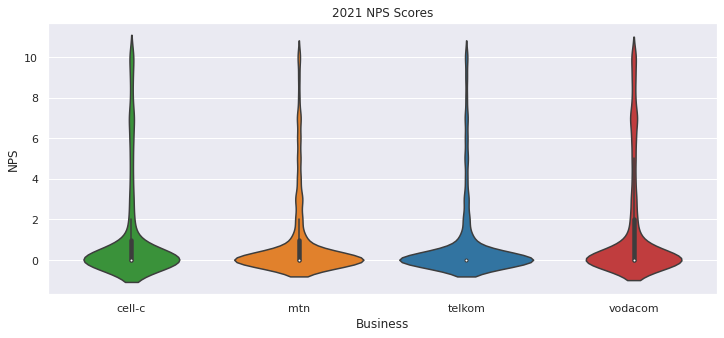

In [58]:
sns.violinplot(
    data=df_eda,
    x="business_slug", 
    y="nps_rating").set(
        title='2021 NPS Scores',
        xlabel='Business',
        ylabel='NPS')    

#### 1) NPS Count

The chart below shows that for all the businesses, the NPS ratings that are received in response to follow-up email track with the total number of ratings shown in the previous section. Therefore, we can conclude that customers are still active on Hellopeter for all four businesses in terms of posting reviews and responding to follow-up NPS requests.

In [59]:
# group the data for nps ratings received
df_nps_grouped = df_eda.groupby('business_slug').resample('M', on='created_at').agg({
    'nps_rating': 'count',
    'id': 'count',
    'replies': 'sum'
}).rename(columns = {'id':'reviews'})

df_nps_grouped['month'] = df_nps_grouped.index.get_level_values('created_at').strftime('%b')

[Text(0.5, 1.0, '2021 NPS ratings received'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'NPS Ratings')]

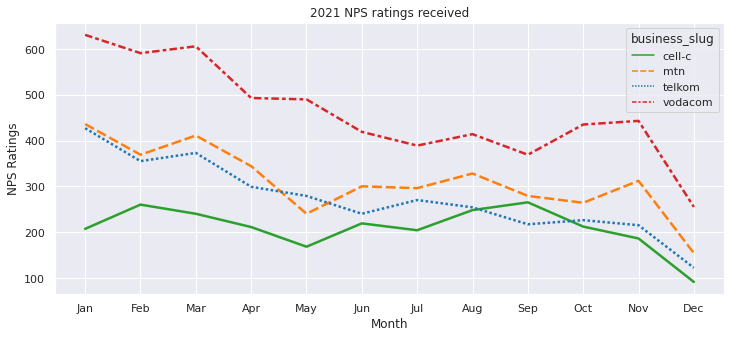

In [60]:
sns.lineplot(
    data=df_nps_grouped,
    x='month',
    y='nps_rating',
    hue='business_slug',
    style='business_slug',
    linewidth=2.5).set(
        title='2021 NPS ratings received',
        xlabel='Month',
        ylabel='NPS Ratings')

### C. Replies

It is interesting to note from the plot below that neither _MTN_ nor _Telkom_ is replying to user reviews (customer complaints). Confirming this, looking at the respective Hellopeter pages of the following notices are currently shown:

- [MTN](https://www.hellopeter.com/mtn) - "We are committed to delivering positive customer experiences and have a wide selection of channels where you can contact us. While we are listed as a "company that responds" on Hello Peter, we recommend the below online channels for prioritised experience"
- [Telkom](https://www.hellopeter.com/telkom) - "Please note that Telkom will soon no longer be a business that responds on Hello peter and we urge all of our customers to contact us via Twitter or Facebook for assistance so that our Social Media Special forces team can help resolve any issue"

However, as shown in the previous section, their customer base is still highly active on the platform, these companies are therefore potentially not benefitting from the opportunities that the reviews reveal and might be creating further customer frustration by refusing to reply to reviews. The fact that these companies are not responding to customer complaints might also support the previous hypothesis that organisations who respond can improve customer perception to improve NPS ratings. 

In [61]:
df_melted = df_nps_grouped.reset_index().melt(
    id_vars=['business_slug', 'month'], 
    value_vars=['reviews', 'replies'])

#df_melted

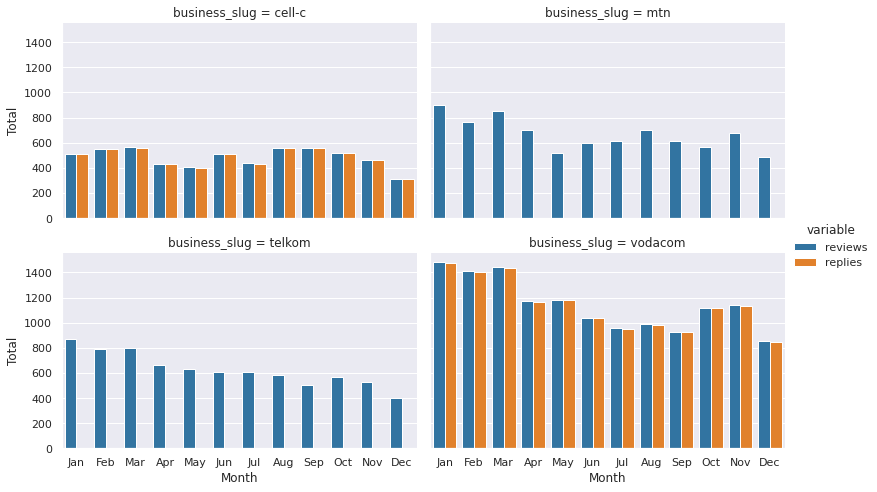

In [62]:
sns.catplot(x="month", y="value",
                hue="variable", col="business_slug",
                data=df_melted, kind="bar",
                col_wrap=2,
                palette='tab10',
    height=3.5, aspect=1.6).set(
        xlabel='Month',
        ylabel='Total')    

### D. Review Length

The box plot of the review length (in characters) shows incredibly long outliers. Sometimes this is the result of a long email thread with the complete history, and in other examples, it is very detailed information being provided. However, only `4%` of reviews are in excess of `2,000` characters. Therefore, these outliers could be considered for removal when doing the complete NLP analysis.

[Text(0.5, 1.0, '2021 Review Length'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Review Length')]

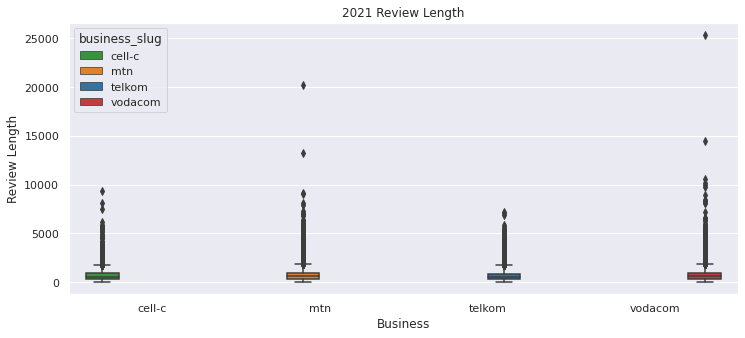

In [63]:
sns.boxplot(
    data=df_eda,
    x="business_slug", 
    y="review_length",
    hue="business_slug").set(
        title='2021 Review Length',
        xlabel='Business',
        ylabel='Review Length')

In [64]:
length_cutoff = 2000
df_long_reviews = df_eda[df_eda.review_length > length_cutoff].sort_values(by='review_length', ascending=False)

print('Cutoff  :', length_cutoff)
print('Reviews :', df_long_reviews.shape[0])
print('Ratio   : %.2f' % (float(df_long_reviews.shape[0]) / df_reviews.shape[0]))


Cutoff  : 2000
Reviews : 1573
Ratio   : 0.04


The same box plots are created without the outliers to understand the review length better. It appears that the length of customer reviews is very similar for each business, with perhaps _Telkom_ customers being slightly less verbose.

[Text(0.5, 1.0, '2021 Review Length (without outliers)'),
 Text(0.5, 0, 'Business'),
 Text(0, 0.5, 'Review Length')]

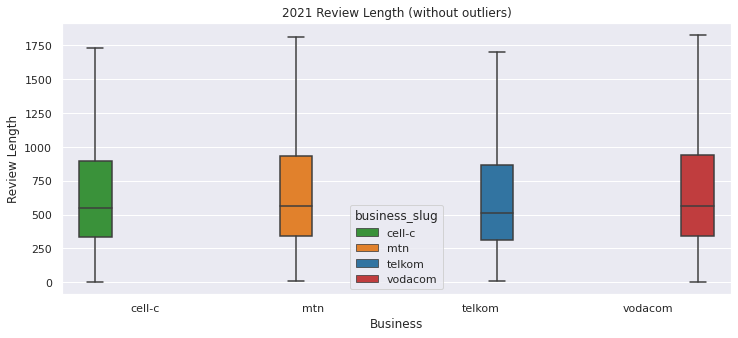

In [65]:
sns.boxplot(
    data=df_eda,
    x="business_slug", 
    y="review_length",
    hue="business_slug",
    showfliers=False).set(
        title='2021 Review Length (without outliers)',
        xlabel='Business',
        ylabel='Review Length')    

#### 1) Is there a link between the Review Rating and the Content-Length?

[Text(0.5, 1.0, 'Review Rating vs Review Length'),
 Text(0.5, 0, 'Review Length'),
 Text(0, 0.5, 'Review Rating')]

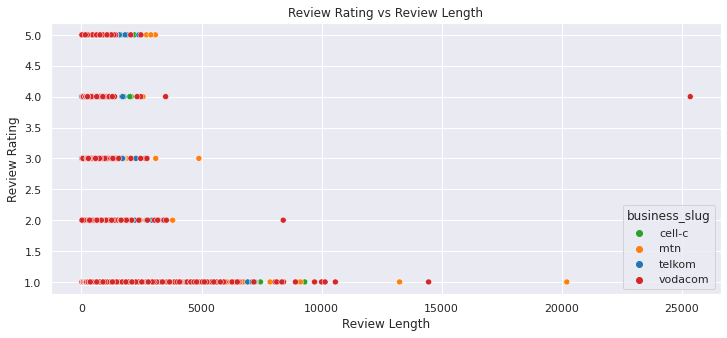

In [66]:
sns.scatterplot(
    data=df_eda,
    x="review_length", 
    y="review_rating",
    hue="business_slug").set(
        title='Review Rating vs Review Length',
        xlabel='Review Length',
        ylabel='Review Rating')  

In [67]:
df_rating_grouped = df_eda.groupby(['business_slug', 'review_rating']).agg({
    'nps_rating': 'mean',
    'id': 'count',
    'review_length': 'median'
}).rename(columns = {'id':'reviews'})


There seems to be a link between the length of customer reviews and the ratings. Where compliments are given (rating 4 & 5), the review length seems to be generally shorter.

[Text(0.5, 1.0, 'Link between Rating and Review Length'),
 Text(0.5, 0, 'Review Rating'),
 Text(0, 0.5, 'Review Length')]

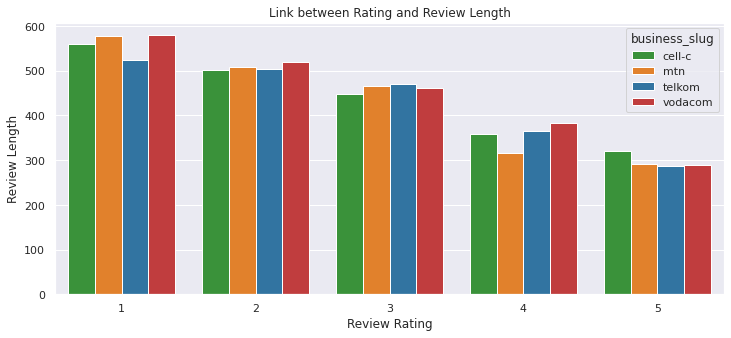

In [68]:
sns.barplot(
    data=df_rating_grouped.reset_index(),
    x='review_rating',
    y='review_length',
    hue='business_slug').set(
        title='Link between Rating and Review Length',
        xlabel='Review Rating',
        ylabel='Review Length') 

## References

[1]	D. Ellis, “Customer Complaint Behaviour and Companies’ Recovery Initiatives: The Case of the Hello Peter Website.” [Online]. Available: https://www.researchgate.net/publication/266732772

[2]	M. Sophia Van Heerden, “A CONTENT ANALYSIS OF USER-GENERATED CONTENT OF THE SEVEN ORIGINAL EQUIPMENT MANUFACTURER BRANDS IN SOUTH AFRICA MASTER OF COMMERCE in the subject of,” 2020.

[3]	D. Ramage, E. Rosen, J. Chuang, C. D. Manning, and D. A. Mcfarland, “Topic Modeling for the Social Sciences,” 2009.

[4]	“About reviews Archives - Hellopeter Blog.” https://blog.hellopeter.com/content/faqs/about-reviews (accessed Dec. 28, 2021).

[5]	“M-Net - Carte Blanche.” https://m-net.dstv.com/show/carte-blanche/season/33/about (accessed Dec. 28, 2021).

[6]	“Your Net Promoter Score - Hellopeter Blog.” https://blog.hellopeter.com/faqs/your-net-promoter-score (accessed Dec. 23, 2021).

[7]	“Vodacom vs MTN vs Telkom vs Cell C – how much money mobile networks make per subscriber in South Africa,” BusinessTech, Nov. 17, 2021. https://businesstech.co.za/news/mobile/537492/vodacom-vs-mtn-vs-telkom-vs-cell-c-how-much-money-mobile-networks-make-per-subscriber-in-south-africa/ (accessed Dec. 25, 2021).